# Import Library

In [51]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.preprocessing import QuantileTransformer,StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn import tree

from sklearn import svm
from sklearn.utils import resample
sc_X=0
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Bank_Dataset


In [33]:
bank_data_full=pd.read_csv('bank.csv')
X=bank_data_full.loc[bank_data_full.balance>0].copy()
bank_data_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


a.There are 7 Independent variables:

    1.Age(Numeric)
    2.Balance: average yearly balance, in euros (numeric)
    3.Day: last contact day of the month (numeric 1 -31)
    4.Duration: last contact duration, in seconds (numeric).
    5.Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 
    6.pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    7.previous: number of contacts performed before this campaign and for this client (numeric)

b.There are 8 Ordinal Categorical Variables:

    1.Job : type of job 
    2.Marital : marital status 
    3.Education
    4.Default: has credit in default? (categorical: 'no','yes','unknown')
    5.Housing: has housing loan? (categorical: 'no','yes','unknown')
    6.Loan: has personal loan? (categorical: 'no','yes','unknown')
    7.Contact: contact communication type (categorical:'cellular','telephone')
    8.poutcome: outcome of the previous marketing campaign(categorical: 'failure','nonexistent','success')

c.And the Target variable is binary category variable(desired target):

    Target:has the client subscribed a term deposit? (binary: 'yes', 'no')


# Exploratory Data Analysis

# General Cleaning

In [34]:
#Dropping those rows which have a negative value of Balance

print(bank_data_full['balance'].min())
X=bank_data_full.loc[bank_data_full.balance>0].copy()


-3313


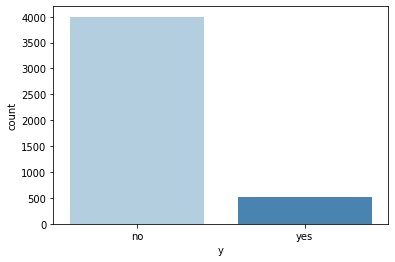

No : 88.48
Yes : 11.52


In [35]:
sns.countplot(x='y',data=bank_data_full,palette='Blues')
plt.show()
print("No :",round(len(bank_data_full[bank_data_full['y']!="yes"])*100/len(bank_data_full),2))
print("Yes :",round(len(bank_data_full[bank_data_full['y']=="yes"])*100/len(bank_data_full),2))

There is an imbalance in the dataset

# A)Analysis on Marital Status


In [42]:
#Getting the number of people with their marital status
bank_data_full.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

* From the barplot below we can observe that the number of **Married people having bank accounts are higher than those of single and divorced people.**
* From these observations we can infer that people who are married **are more cautious about their future financial status than those people who are single.**

Text(0.5, 1.0, 'Count by Marital Status')

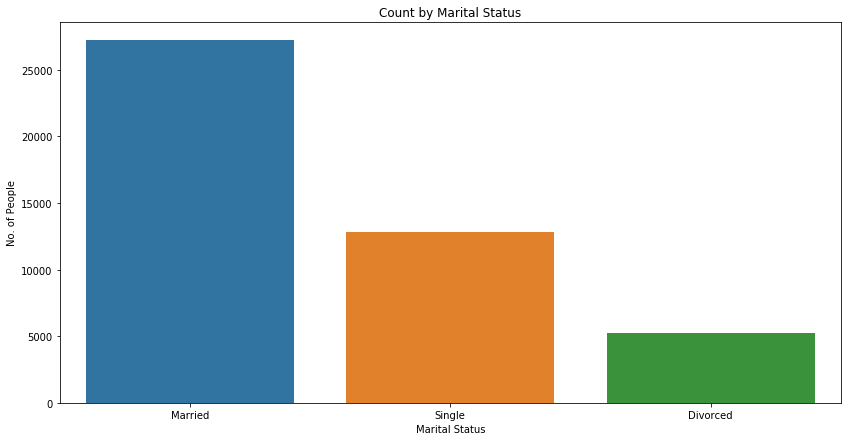

In [43]:
plt.figure(figsize=(14,7))
sns.barplot(x=['Married','Single','Divorced'],y=[27214,12790,5207])
plt.xlabel('Marital Status')
plt.ylabel('No. of People')
plt.title('Count by Marital Status')

In [44]:
marriage_stat=X.groupby('marital').balance.unique()
marriage_stat

marital
divorced    [2, 270, 63, 506, 2586, 989, 59, 91, 1, 164, 1...
married     [2143, 2, 1506, 231, 121, 6, 71, 162, 229, 52,...
single      [29, 1, 447, 593, 390, 13, 23, 255, 265, 243, ...
Name: balance, dtype: object

In [45]:
count_1=[]
for i in range(len(marriage_stat)):
    add=0
    for j in range(len(marriage_stat[i])):
        add=add+marriage_stat[i][j]
    avg= add/len(marriage_stat[i])
    count_1.append(avg)
count_1

[2385.064412238325, 4314.48412541905, 3237.543538038497]

* As shown in the barplot below the **mean bank balance of married people are more than those of single and divorced people.** The main reason for this trend can be attributed due to the larger number of married people having accounts than those of the other categories.

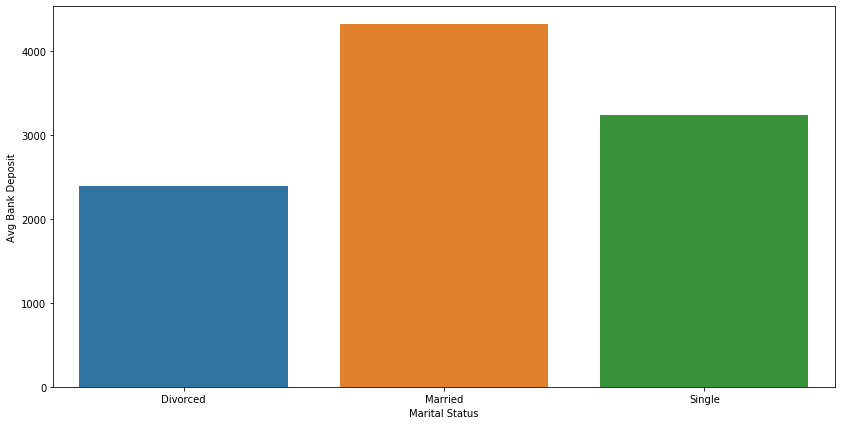

In [46]:
plt.figure(figsize=(14,7))
plt.xlabel("Marital Status")
plt.ylabel("Avg Bank Deposit")
sns.barplot(x=['Divorced','Married','Single'],y=count_1)

# B)Analysis by Education Level

In [47]:
#Getting the number of people with their education Level
bank_data_full.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

* The main takeaway from the below graph is that **people who have higher levels of education know about the benefits of opening a bank account and thus their number is higher.**
* Interesteringly the **no. of people having secondary level of education are more than those who have tertiary knowledge**.It can be because there are a few amount of people who posess tertiary knowledge in our country.

Text(0.5, 1.0, 'No. of Accounts per Education Level')

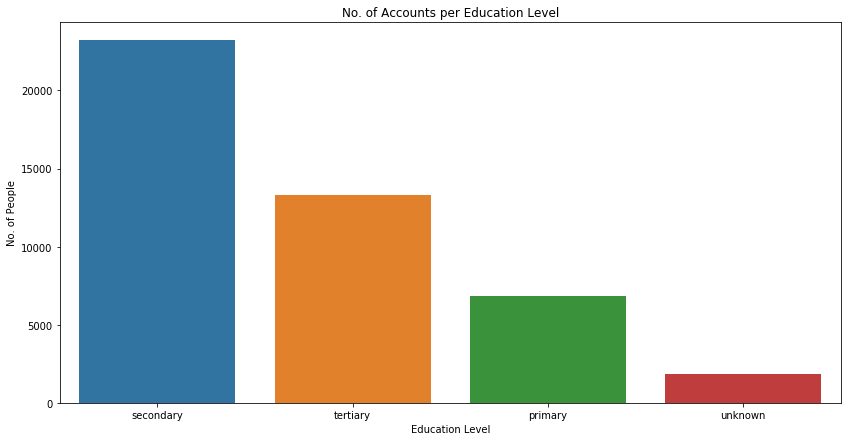

In [48]:
plt.figure(figsize=(14,7))
sns.barplot(x=['secondary','tertiary','primary','unknown'],y=list(bank_data_full.education.value_counts()))
plt.xlabel("Education Level")
plt.ylabel("No. of People")
plt.title("No. of Accounts per Education Level")

## C)Analysis By Occupation

In [49]:
#Getting the number of Jobs
X.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'housemaid', 'unemployed', 'student'], dtype=object)

In [50]:
job_count=X.groupby('job').balance.unique()
job_count

job
admin.           [270, 390, 13, 39, 506, 206, 2343, 45, 290, 61...
blue-collar      [1506, 52, 723, 23, 104, 1291, 306, 24, 249, 1...
entrepreneur     [2, 113, 243, 19, 294, 100, 901, 236, 155, 106...
housemaid        [947, 195, 965, 17, 109, 203, 6920, 98, 365, 8...
management       [2143, 231, 447, 779, 255, 378, 10635, 49, 424...
retired          [121, 229, 60, 529, 96, 100, 486, 81, 30, 216,...
self-employed    [137, 3, 7, 19, 672, 16, 292, 107, 935, 918, 4...
services         [162, 50, 2586, 179, 790, 25, 91, 1, 164, 31, ...
student          [298, 25, 423, 82, 157, 34, 252, 209, 948, 110...
technician       [29, 593, 6, 71, 265, 839, 63, 989, 1205, 1937...
unemployed       [42, 293, 41, 13, 219, 10, 408, 5345, 387, 11,...
unknown          [1, 28, 27, 414, 50, 2398, 106, 3111, 2272, 32...
Name: balance, dtype: object

In [51]:
#Code to get the mean of balance deposited in the bank by occupation
count=[]
for i in range(len(job_count)):
    add=0
    for j in range(len(job_count[i])):
        add=add+job_count[i][j]
    avg= add/len(job_count[i])
    count.append(avg)
count

[2237.6402373247033,
 2583.24881775191,
 2400.1453201970444,
 1988.2185792349726,
 3643.945877109201,
 2713.3273026315787,
 2276.9053905390538,
 1990.5746031746032,
 1648.768115942029,
 2666.298985801217,
 2115.990990990991,
 2156.0616113744077]

* It is clear upon observation that **people having their jobs in the management sector are clearly hiher paid than people who have their jobs as technician,services,self-employed etc.**
* One interesting to note here is that retired people also have their avg bank balance close to people who are currently working.**Most of it is probably their savings which they have accumulated over time.**

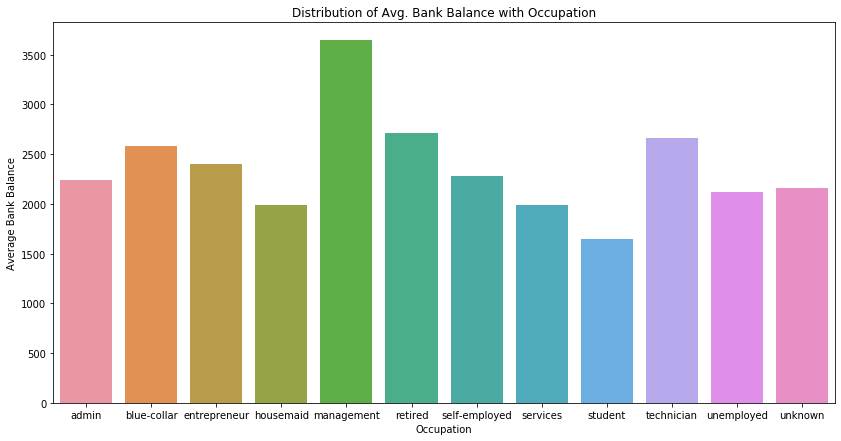

In [52]:
plt.figure(figsize=(14,7))
plt.xlabel("Occupation")
plt.ylabel("Average Bank Balance")
plt.title("Distribution of Avg. Bank Balance with Occupation")
sns.barplot(x=['admin','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown'],y=count)

## D) Analysis by Age Groups

* From the following graph we can see that the **number of people between the working age of 30-60 has higer balance whereas people below 25(generally students) have less balance.**
* We also note that **after the age of 60 people retire from their jobs and thus their balance are somewhat lower than those people in the age group of 30-60.**

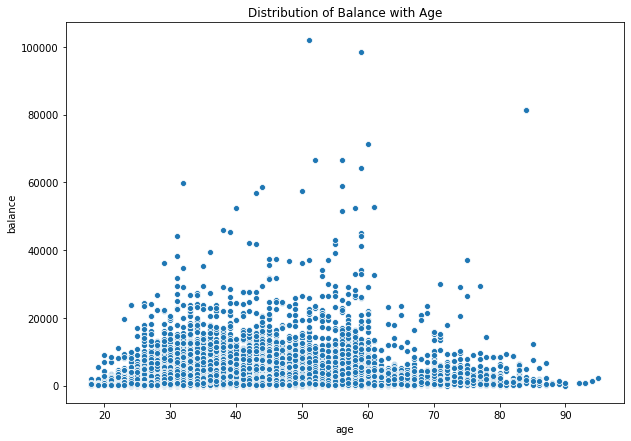

In [53]:
plt.figure(figsize=(10,7))
plt.title("Distribution of Balance with Age")
sns.scatterplot(x=X.age,y=X.balance)

## D)Correlation Matrix

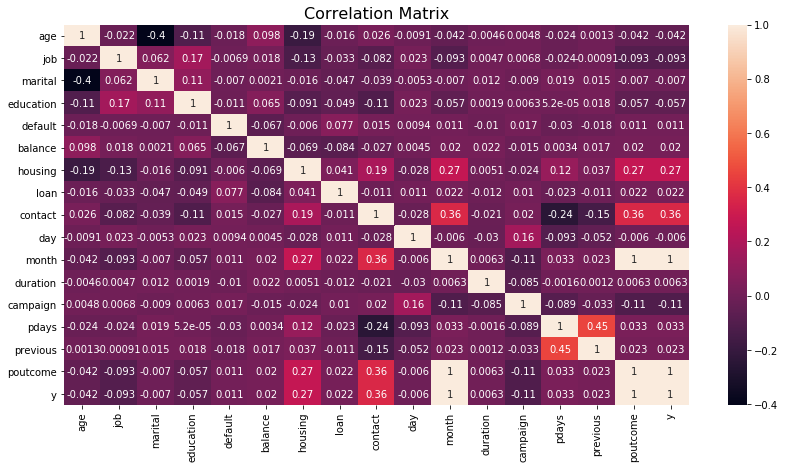

In [54]:
plt.figure(figsize=(14,7))
bank_data_full['y']=pd.Series(np.where(bank_data_full.y.values == 'yes', 1, 0),bank_data_full.index)
labelencoder_X = LabelEncoder()

bank_data_full['job']      = labelencoder_X.fit_transform(bank_data_full['job']) 
bank_data_full['marital']  = labelencoder_X.fit_transform(bank_data_full['marital']) 
bank_data_full['education']= labelencoder_X.fit_transform(bank_data_full['education']) 
bank_data_full['default']  = labelencoder_X.fit_transform(bank_data_full['default']) 
bank_data_full['housing']  = labelencoder_X.fit_transform(bank_data_full['housing']) 
bank_data_full['loan']     = labelencoder_X.fit_transform(bank_data_full['loan']) 
bank_data_full['contact']  = labelencoder_X.fit_transform(bank_data_full['contact']) 
bank_data_full['month']    = labelencoder_X.fit_transform(bank_data_full['month']) 
bank_data_full['poutcome'] = labelencoder_X.fit_transform(bank_data_full['month']) 
bank_data_full['y'] = labelencoder_X.fit_transform(bank_data_full['month']) 

sns.heatmap(bank_data_full.corr(), annot=True)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

* There's high focus on poutcome and month(less on days).
* Houing, Contact and poutcome also has High Correlation

* 1.The ages are not that much important and dont make sense relate with other variables will not tell any insight.Just looking at the graphs we cannot conclude if age have a high effect to our Target variable.

* 2.Here we can see the percentage of the outliers for 'Age' is less, so we can fit the model with and without them.

* 3.If we consider the Job attribute we can see the count of 'Blue-collar' is higher than the other .Also the count for 'Management' is noticeable.

* 4.Married people are more ,we can see in graph clearly.

* 5.The clients having secondary education are more .And the clients having unknown eduction are less .

* 6.The clients having bydefault credit are less than those who don't have bydefault credit.

* 7.The clients having Housing loan are more by almost 5000 count than the clients who don't have Housing Loan.

* 8.The clients having Personal loan are less than clients don't have Personal loan.Difference is almost 30000 count.

* 9.The count of a clients who can be contacted by Cellular is high that the others.

* 10.The no. of contacts performed in May month is highest than the other months.But it is not sure as the year is not mentioned in the dataset.

* 11.Most of the contacts are done in between 8th-21st day of the particular month.And Also there is no outlier present.

* 12.Just looking at the graphs we cannot conclude if duration have a high effect to our Target variable.Here we can see the percentage of the outliers is less.But count is high means 643 count is not less I think so.

* 13.The percentage of presence of outlier is less as we can see.So we can fit the model with or without this attribute.

* 14.The success of the previous marketing campaign is not noticeable as we can see in graph.But still I am not sure as there are so many unknown options present.

* 15.I think for the Jobs, Marital and Education  the best analisys is just the count of each variable, if we related with the other ones its is not conclusive.

* 16.The Mareied people are more subscribing a term deposit. But here is also 50 percente chances to suscribe by clients as we can see in graphs.

* 17.here are outliers present in each education criteria . But the clients having primary education are more who have subscribed a term deposit.

* 18.The clients who don't have taken housing loan have subscribed a term deposite with more than 50% chances.

# Pre-Process

In [118]:
def prerun(d):
    global sc_X
    labelencoder_X = LabelEncoder()
    if d=="bank-full.csv":
        df = pd.read_csv(d)
        df['y']=pd.Series(np.where(df.y.values == 'yes', 1, 0),df.index)
        df['job']=labelencoder_X.fit_transform(df['job']) 
        df['marital']=labelencoder_X.fit_transform(df['marital']) 
        df['education']=labelencoder_X.fit_transform(df['education']) 
        df['default']=labelencoder_X.fit_transform(df['default']) 
        df['housing']=labelencoder_X.fit_transform(df['housing']) 
        df['loan']=labelencoder_X.fit_transform(df['loan']) 
        df['contact']=labelencoder_X.fit_transform(df['contact']) 
        df['month']=labelencoder_X.fit_transform(df['month'])
        df['poutcome'].replace(['unknown','failure', 'success',"other"], [1,2,3,4], inplace  = True)

        try:
            df.drop('yes',axis=1)
        except:
            df=df
        df=df.drop('day',axis=1)
        def age(data):
            data.loc[data['age'] <= 30, 'age'] = 1
            data.loc[(data['age']>30)&(data['age']<=45),'age'] = 2
            data.loc[(data['age']>45)&(data['age']<=70),'age'] = 3
            data.loc[(data['age']>70)&(data['age']<=100),'age'] = 4
            return dataframe
        age(df);
        def duration(data):
            data.loc[data['duration']<=100,'duration'] = 1
            data.loc[(data['duration']>100)&(data['duration']<=180),'duration']=2
            data.loc[(data['duration']>180)&(data['duration']<=320),'duration']=3
            data.loc[(data['duration']>320)&(data['duration']<=640),'duration']=4
            data.loc[data['duration']>650,'duration']=5
            return data
        duration(df);
        Max = df[df['y'] == 0]
        Min = df[df['y'] == 1]
        Min = resample(Min,replace=True,n_samples= 9280) 
        df= pd.concat([Max, Min])
        X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis = 1),df['y'], test_size = 0.2, random_state = 101)
        sc_X = QuantileTransformer(output_distribution='uniform')
        #sc_X=StandardScaler()
        sc_X.fit(X_train)
        X_train=sc_X.transform(X_train)
        X_test=sc_X.transform(X_test)

        #return df
        return X_train, X_test, y_train, y_test
    else:
        df = pd.read_csv(d)
        df['y']=pd.Series(np.where(df.y.values == 'yes', 1, 0),df.index)
        df['job']=labelencoder_X.fit_transform(df['job']) 
        df['marital']=labelencoder_X.fit_transform(df['marital']) 
        df['education']=labelencoder_X.fit_transform(df['education']) 
        df['default']=labelencoder_X.fit_transform(df['default']) 
        df['housing']=labelencoder_X.fit_transform(df['housing']) 
        df['loan']=labelencoder_X.fit_transform(df['loan']) 
        df['contact']=labelencoder_X.fit_transform(df['contact']) 
        df['month']=labelencoder_X.fit_transform(df['month'])
        df['poutcome'].replace(['unknown','failure', 'success',"other"], [1,2,3,4], inplace  = True)

        try:
            df.drop('yes',axis=1)
        except:
            df=df
        df=df.drop('day',axis=1)
        def age(data):
            data.loc[data['age']<=30,'age'] = 1
            data.loc[(data['age']>30)&(data['age']<=45),'age']=2
            data.loc[(data['age']>45)&(data['age']<=70),'age']=3
            data.loc[(data['age']>70)&(data['age']<=100),'age']=4
            return dataframe
        age(df);
        def duration(data):
            data.loc[data['duration']<=100,'duration']=1
            data.loc[(data['duration']>100)&(data['duration']<=180),'duration']=2
            data.loc[(data['duration']>180)&(data['duration']<=320),'duration']=3
            data.loc[(data['duration']>320)&(data['duration']<=640),'duration']=4
            data.loc[data['duration']>650,'duration']=5
            return data
        duration(df);
        x_train=sc_X.transform(df.drop('y', axis = 1))
        y_test=df['y']
        return x_train,y_test



# Check Accuracy and Confusion Matrix

In [143]:
def ACC_PLOT(y_true, y_pred,figsize=(6,6)):
    cm = confusion_matrix(y_true,y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= 'plasma_r', annot=annot, fmt='', ax=ax).set_title('Confusion Matrix')
    Accuracy=round(accuracy_score(y_true,y_pred) *100,2)
    print("\n\t\tClassification Report\n\n",classification_report(y_true, y_pred))
    print("------------------------------------------------------\n\n\t\t| Accuracy= {:.2f} % |\n\n------------------------------------------------------".format(Accuracy))
    return Accuracy


# Decision Tree

0.9714664897146649


No handles with labels found to put in legend.



		Classification Report

               precision    recall  f1-score   support

           0       0.95      0.92      0.93      4000
           1       0.49      0.63      0.55       521

    accuracy                           0.88      4521
   macro avg       0.72      0.77      0.74      4521
weighted avg       0.90      0.88      0.89      4521

------------------------------------------------------

		| Accuracy= 88.23 % |

------------------------------------------------------


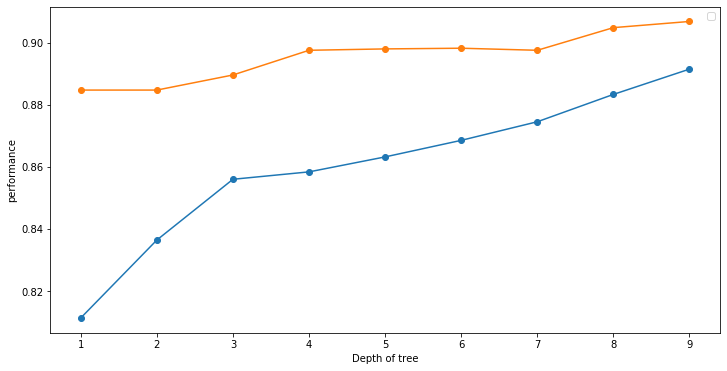

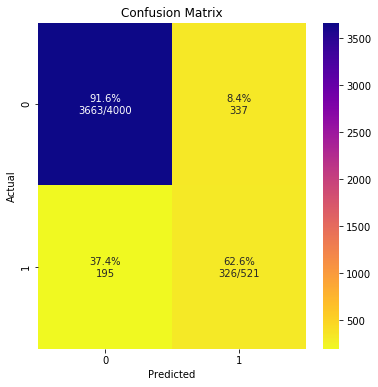

In [117]:
def DECISION_TREE(X_train, X_test, Y_train, Y_test):

    dt_model = DecisionTreeClassifier(random_state=10)
    dt_model.fit(X_train, Y_train)
    dt_model.score(X_test, Y_test)
    y_pred = dt_model.predict_proba(X_test)[:,1]

    new_y = []
    for i in range(len(y_pred)):
      if y_pred[i]<0.6:
        new_y.append(0)
      else:
        new_y.append(1)
    print(accuracy_score(Y_test, new_y))
    train_accuracy = []
    test_accuracy = []
    for depth in range(1,10):
      dt_model = DecisionTreeClassifier(max_depth=depth, random_state=10)
      dt_model.fit(X_train, Y_train)
      train_accuracy.append(dt_model.score(X_train, Y_train))
      test_accuracy.append(dt_model.score(X_test, Y_test))
    frame = pd.DataFrame({'max_depth':range(1,10), 'train_acc':train_accuracy, 'test_acc':test_accuracy})
    plt.figure(figsize=(12,6))
    plt.plot(frame['max_depth'], frame['train_acc'], marker='o')
    plt.plot(frame['max_depth'], frame['test_acc'], marker='o')
    plt.xlabel('Depth of tree')
    plt.ylabel('performance')
    plt.legend()
    dt_model = DecisionTreeClassifier(max_depth=8, max_leaf_nodes=25, random_state=10)
    dt_model.fit(X_train, Y_train)
    y_pred=dt_model.predict(X_test)
    return ACC_PLOT(Y_test,y_pred)
    #from sklearn import tree
    #decision_tree = tree.export_graphviz(dt_model,out_file='tree.dot',feature_names=X_train.columns,max_depth=2,filled=True)
DECISION_TREE(X_train, X_test, Y_train, Y_test)

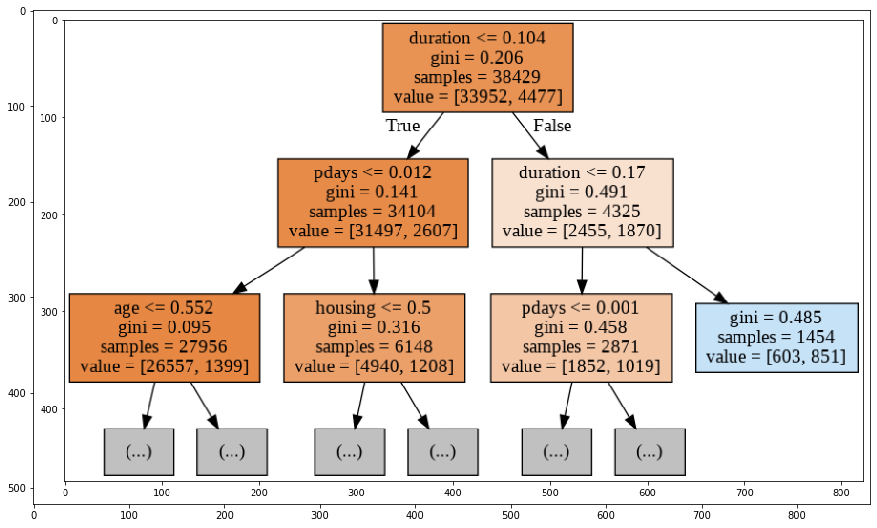

In [68]:
image = plt.imread('tree.png')
plt.figure(figsize=(15,15))
plt.imshow(image)

# KNN


		Classification Report

               precision    recall  f1-score   support

           0       0.90      0.96      0.93      4000
           1       0.44      0.22      0.29       521

    accuracy                           0.88      4521
   macro avg       0.67      0.59      0.61      4521
weighted avg       0.85      0.88      0.86      4521

------------------------------------------------------

		| Accuracy= 87.83 % |

------------------------------------------------------


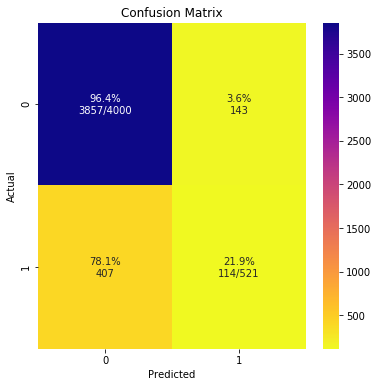

In [110]:
def KNN(X_train, X_test, Y_train, Y_test):
    knn = KNeighborsClassifier(n_neighbors = 191)
    knn.fit(X_train,Y_train)
    y=knn.predict(X_test)
    return ACC_PLOT(Y_test,y)
KNN(X_train, X_test, Y_train, Y_test)

# SVM


		Classification Report

               precision    recall  f1-score   support

           0       0.93      0.95      0.94      4000
           1       0.56      0.46      0.50       521

    accuracy                           0.90      4521
   macro avg       0.74      0.70      0.72      4521
weighted avg       0.89      0.90      0.89      4521

------------------------------------------------------

		| Accuracy= 89.54 % |

------------------------------------------------------


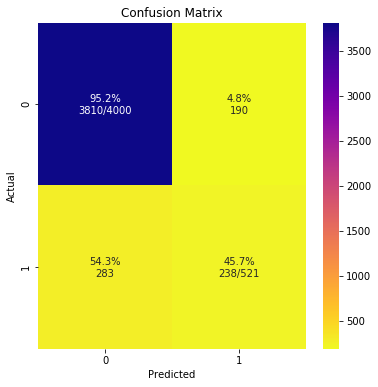

In [109]:
def SVM(X_train, X_test, Y_train, Y_test):
    clf = svm.SVC(kernel='rbf')
    clf.fit(X_train,Y_train)
    y=clf.predict(X_test)
    return ACC_PLOT(Y_test,y)
SVM(X_train, X_test, Y_train, Y_test)

# Random Forest


		Classification Report

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4000
           1       0.94      0.87      0.90       521

    accuracy                           0.98      4521
   macro avg       0.96      0.93      0.95      4521
weighted avg       0.98      0.98      0.98      4521

------------------------------------------------------

		| Accuracy= 97.85 % |

------------------------------------------------------


97.85

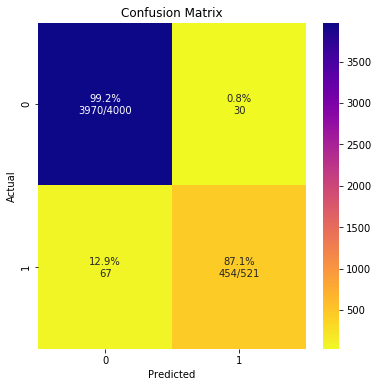

In [144]:
def RANDOM_FOREST(X_train, X_test, Y_train, Y_test):
    random_forest=RandomForestClassifier()
    random_forest.fit(X_train,Y_train) 
    y=random_forest.predict(X_test)
    return ACC_PLOT(Y_test,y)
RANDOM_FOREST(X_train, X_test, Y_train, Y_test)
#

# Linear SVC + Random Forest


		Classification Report

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4000
           1       0.94      0.88      0.91       521

    accuracy                           0.98      4521
   macro avg       0.96      0.94      0.95      4521
weighted avg       0.98      0.98      0.98      4521

------------------------------------------------------

		| Accuracy= 97.94 % |

------------------------------------------------------


97.94

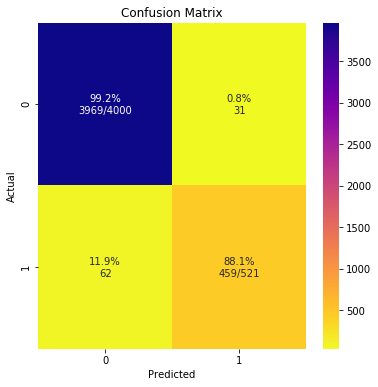

In [148]:
def LinearSVC_RandomForest(X_train, X_test, Y_train, Y_test):
    lsvc=LinearSVC(C=0.05, penalty="l1", dual=False,max_iter=2000).fit(X_train,Y_train)
    lsvc_model=SelectFromModel(lsvc, prefit=True)
    X_train=lsvc_model.transform(X_train)
    random_forest=RandomForestClassifier()
    random_forest.fit(X_train, Y_train)   
    model1=[lsvc_model,random_forest]
    X_test=model1[0].transform(X_test)
    y_pred=model1[1].predict(X_test)
    return ACC_PLOT(Y_test,y_pred)
LinearSVC_RandomForest(X_train, X_test, Y_train, Y_test)

# XGBoost


		Classification Report

               precision    recall  f1-score   support

           0       0.96      0.96      0.96      4000
           1       0.70      0.69      0.70       521

    accuracy                           0.93      4521
   macro avg       0.83      0.83      0.83      4521
weighted avg       0.93      0.93      0.93      4521

------------------------------------------------------

		| Accuracy= 93.01 % |

------------------------------------------------------


93.01

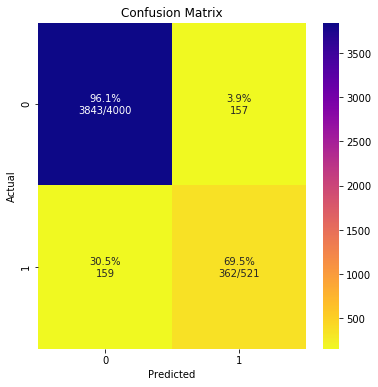

In [151]:
def XGBOOST(X_train, X_test, Y_train, Y_test):
    model = XGBClassifier()
    model.fit(X_train, Y_train)
    y_pred=model.predict(X_test)
    return ACC_PLOT(Y_test,y_pred)
XGBOOST(X_train, X_test, Y_train, Y_test)

In [119]:
'''
def trainmodel(X_train,Y_train):
    model = XGBClassifier()
    model.fit(X_train, Y_train)
    return model
model=trainmodel(X_train,Y_train)
'''

In [120]:
'''
def predict(model,X_test):
    return model.predict(X_test)
'''

In [152]:
X_train, X_test, Y_train, Y_test=prerun("bank-full.csv")

In [153]:
dt_model = DecisionTreeClassifier(max_depth=8, max_leaf_nodes=25, random_state=10)
dt_model.fit(X_train,Y_train)


knn = KNeighborsClassifier(n_neighbors = 191)
knn.fit(X_train,Y_train)

random_forest=RandomForestClassifier()
random_forest.fit(X_train,Y_train)  

clf = svm.SVC(kernel='rbf')
clf.fit(X_train,Y_train)
def trainmodel1(X,y):

    
    lsvc=LinearSVC(C=0.05, penalty="l1", dual=False,max_iter=2000).fit(X, y)
    lsvc_model=SelectFromModel(lsvc, prefit=True)
    X=lsvc_model.transform(X)
    random_forest=RandomForestClassifier()
    random_forest.fit(X, y)   
    model1=[lsvc_model,random_forest]
    return model1
def testmodel1(model1,X):
    X=model1[0].transform(X)
    y_pred=model1[1].predict(X)
    return y_pred


In [162]:
X_test,Y_test=prerun("bank.csv")

In [163]:
y1=model.predict(X_test)
y2=dt_model.predict(X_test)
y3=knn.predict(X_test)
y4=clf.predict(X_test)
y5=random_forest.predict(X_test)
y6=testmodel1(trainmodel1(X_train,Y_train),X_test)


		Classification Report

               precision    recall  f1-score   support

           0       0.96      0.96      0.96      4000
           1       0.70      0.69      0.70       521

    accuracy                           0.93      4521
   macro avg       0.83      0.83      0.83      4521
weighted avg       0.93      0.93      0.93      4521

------------------------------------------------------

		| Accuracy= 93.01 % |

------------------------------------------------------

		Classification Report

               precision    recall  f1-score   support

           0       0.95      0.92      0.93      4000
           1       0.49      0.63      0.55       521

    accuracy                           0.88      4521
   macro avg       0.72      0.77      0.74      4521
weighted avg       0.90      0.88      0.89      4521

------------------------------------------------------

		| Accuracy= 88.23 % |

------------------------------------------------------

		Classification Re

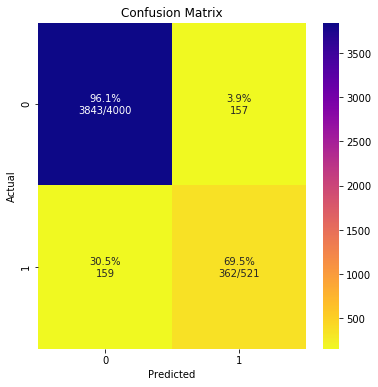

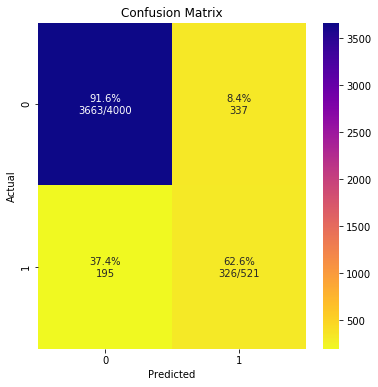

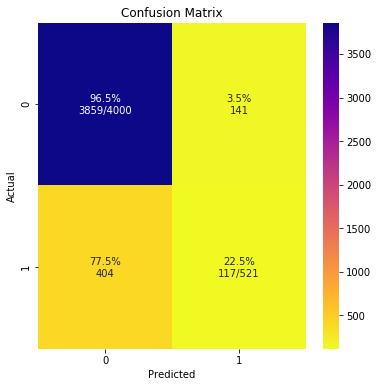

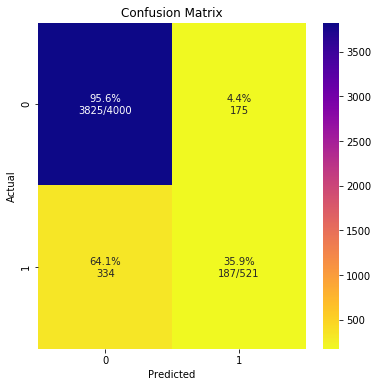

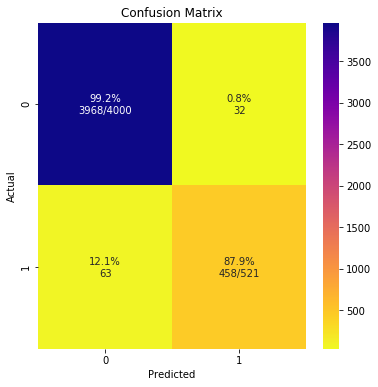

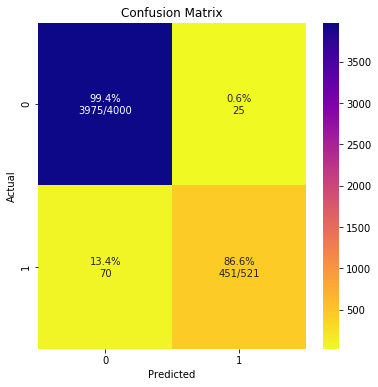

In [164]:
a=ACC_PLOT(Y_test,y1)
b=ACC_PLOT(Y_test,y2)
c=ACC_PLOT(Y_test,y3)
d=ACC_PLOT(Y_test,y4)
e=ACC_PLOT(Y_test,y5)
f=ACC_PLOT(Y_test,y6)

In [165]:
z=[str(a),str(b),str(c),str(d),str(e),str(f)]

In [139]:
import plotly.express as px

the_dict = {'model': ['xgb','decision tree', 'knn','svm','random forest','linear svc + random forest'], 'accuracy': [a,b,c,d,e,f]}
fig = px.bar(the_dict, x='model', y='accuracy', color="model", text=z)
fig.update_traces(textposition='inside', textfont_size=30)

fig.show()